# TESLA - VALUE AT RISK TECHNIQUES 

## 1. QUANTILE METHOD 
## 2. MONTE CARLO SIMULATION 

In [44]:
#Let's go ahead and start with some imports
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# For reading stock data from yahoo
# from pandas.io.data import DataReader

# For time stamps
from datetime import datetime

# For division
from __future__ import division

In [111]:
# Plot defaults 
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 15

In [70]:
# The tech stocks we'll use for this analysis
TSLA = pd.read_csv("https://raw.githubusercontent.com/katariyj/Time-Series-Analysis-on-TESLA/master/TSLA.csv")


In [71]:
TSLA.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-05-02,241.500000,243.190002,234.820007,241.800003,241.800003,3843900
1,2016-05-03,237.360001,238.910004,231.619995,232.320007,232.320007,4302200
2,2016-05-04,230.289993,234.460007,220.399994,222.559998,222.559998,8262500
3,2016-05-05,228.460007,228.639999,209.789993,211.529999,211.529999,11254800
4,2016-05-06,210.869995,216.369995,208.110001,214.929993,214.929993,5685200


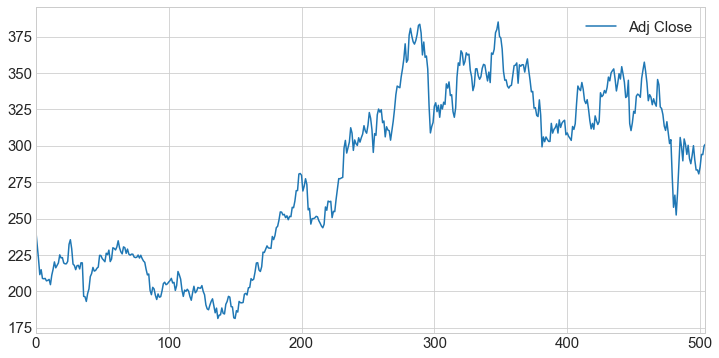

In [112]:
# Let's see a historical view of the closing price
TSLA['Adj Close'].plot(legend=True,figsize=(12,6))

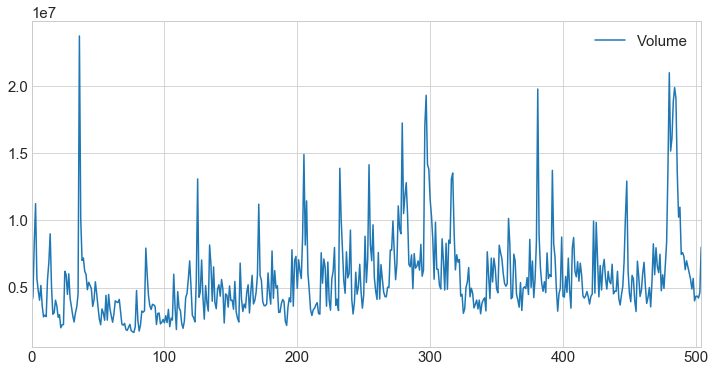

In [113]:
# Now let's plot the total volume of stock being traded each day over the past 2 years
TSLA['Volume'].plot(legend=True,figsize=(12,6))

In [74]:
# Luckily pandas has a built-in rolling mean calculator

# Let's go ahead and plot out several moving averages
ma_day = [10,20,50]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    TSLA[column_name]=pd.rolling_mean(TSLA['Adj Close'],ma)


C:\Users\Jai Katariya\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  
C:\Users\Jai Katariya\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  
C:\Users\Jai Katariya\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
  


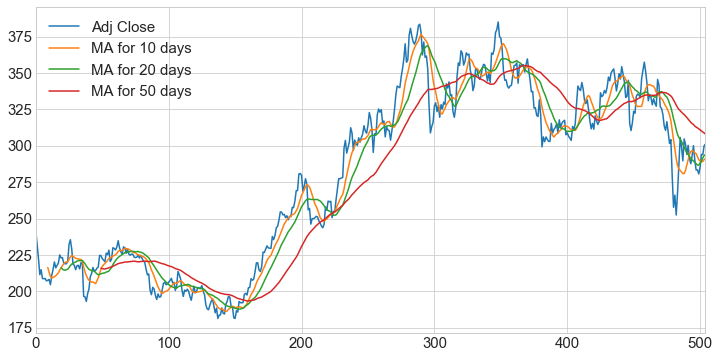

In [114]:
TSLA[['Adj Close','MA for 10 days','MA for 20 days','MA for 50 days']].plot(subplots=False)

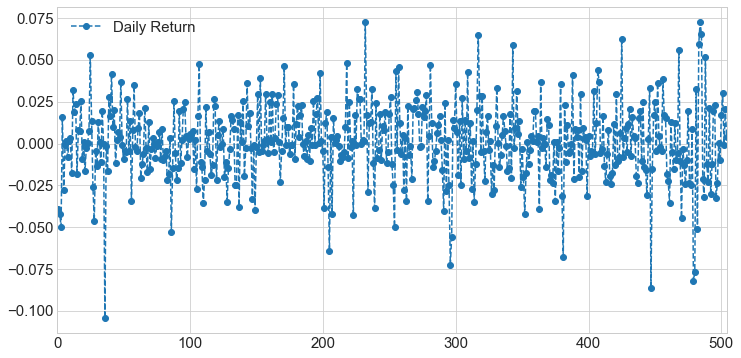

In [115]:
# We'll use pct_change to find the percent change for each day
TSLA['Daily Return'] = TSLA['Adj Close'].pct_change()
# Then we'll plot the daily return percentage
TSLA['Daily Return'].plot(figsize=(12,6),legend=True,linestyle='--',marker='o')

In [77]:
TSLA['Daily Return'].head()

0         NaN
1   -0.039206
2   -0.042011
3   -0.049560
4    0.016073
Name: Daily Return, dtype: float64

In [42]:
TSLA.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,MA for 10 days,MA for 20 days,MA for 50 days,Daily Return
500,2018-04-26,278.750000,285.790009,276.500000,285.480011,285.480011,4356000,289.590997,288.168998,310.850599,0.017065
501,2018-04-27,285.369995,294.470001,283.829987,294.079987,294.079987,4364600,288.964996,289.566497,310.285999,0.030125
502,2018-04-30,293.609985,298.730011,292.500000,293.899994,293.899994,4228200,289.233997,291.637497,309.482599,-0.000612
503,2018-05-01,293.510010,300.820007,293.220001,299.920013,299.920013,4625600,290.456998,293.256998,308.771199,0.020483
504,2018-05-02,298.570007,306.850006,297.779999,301.149994,301.149994,8011300,291.236996,293.967497,308.098799,0.004101


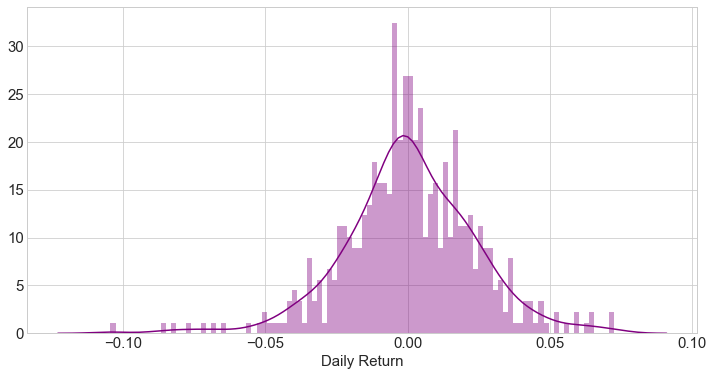

In [116]:
# Note the use of dropna() here, otherwise the NaN values can't be read by seaborn
sns.distplot(TSLA['Daily Return'].dropna(),bins=100,color='purple')

Now we can use quantile to get the risk value for the stock.

In [100]:
returns = TSLA['Daily Return'].dropna()
# The 0.05 empirical quantile of daily returns
returns.quantile(0.05)


-0.03572207236412494

The 0.05 empirical quantile of daily returns is at -0.0357. That means that with 95% confidence, our worst daily loss will not exceed 3.57%. If we have a 1 million dollar investment, our one-day 5% VaR is 0.0357 * 1,000,000 = $35,700.

In [101]:

# The 0.01 empirical quantile of daily returns
returns.quantile(0.01)


-0.06784101546262229

The 0.01 empirical quantile of daily returns is at -0.0678. That means that with 99% confidence, our worst daily loss will not exceed 6.78%. If we have a 1 million dollar investment, our one-day 1% VaR is 0.0678 * 1,000,000 = $67,800.


We'll look at value at risk by implementing a Monte Carlo method.

In [102]:
# Set up our time horizon
days = 730

# Now our delta
dt = 1/days

# Now let's grab our mu (drift) from the expected return data we got for TESLA
mu = returns.mean()

# Now let's grab the volatility of the stock from the std() of the average return
sigma = returns.std()

In [103]:
def stock_monte_carlo(start_price,days,mu,sigma):
    ''' This function takes in starting stock price, days of simulation,mu,sigma, and returns simulated price array'''
    
    # Define a price array
    price = np.zeros(days)
    price[0] = start_price
    # Shock and Drift
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    # Run price array for number of days
    for x in xrange(1,days):
        
        # Calculate Schock
        shock[x] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        # Calculate Drift
        drift[x] = mu * dt
        # Calculate Price
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

Text(0.5,1,u'Monte Carlo Analysis for TESLA')

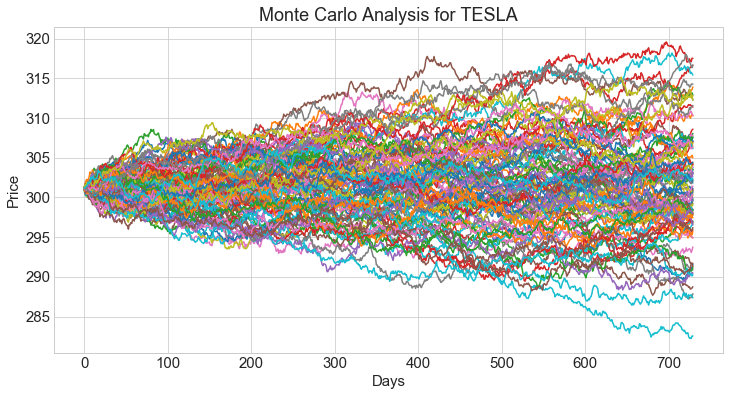

In [117]:
# Get start price from TESLA.tail()
start_price = 301.15

for run in xrange(100):
    figszie=(12,8)
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma) )
plt.xlabel("Days")
plt.ylabel("Price")  
plt.title('Monte Carlo Analysis for TESLA')

In [54]:
# Set a large numebr of runs
runs = 10000

# Create an empty matrix to hold the end price data
simulations = np.zeros(runs)

# Set the print options of numpy to only display 0-5 points from an array to suppress output
np.set_printoptions(threshold=5)

for run in xrange(runs):    
    # Set the simulation data point as the last stock price for that run
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1];


Now that we have our array of simulations, we can go ahead and plot a histogram ,as well as use qunatile to define our risk for this stock.

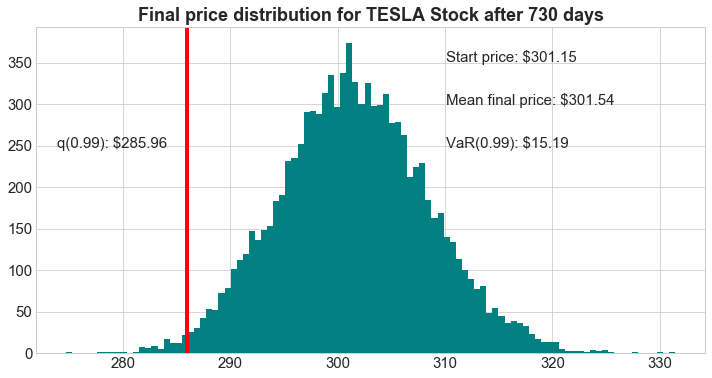

In [118]:
# Now we'lll define q as the 1% empirical qunatile, this basically means that 99% of the values should fall between here
q = np.percentile(simulations, 1)
    
# Now let's plot the distribution of the end prices
plt.hist(simulations,bins=100, color= "teal")

# Using plt.figtext to fill in some additional information onto the plot

# Starting Price
plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price)
# Mean ending price
plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations.mean())

# Variance of the price (within 99% confidence interval)
plt.figtext(0.6, 0.6, "VaR(0.99): $%.2f" % (start_price - q,))

# Display 1% quantile
plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % q)

# Plot a line at the 1% quantile result
plt.axvline(x=q, linewidth=4, color='r')

# Title
plt.title(u"Final price distribution for TESLA Stock after %s days" % days, weight='bold');

Now we have looked at the 1% empirical quantile of the final price distribution to estimate the Value at Risk for the TESLA stock, which looks to be $15.19 for every investment of 301.15 (the price of one inital TESLA stock).


This basically menas for every initial stock you purchase your putting about $15.19 at risk 99% of the time from our Monte Carlo Simulation.